In [1]:
import os

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
import tensorflow as tf
import tensorflow.keras as keras
from scipy import stats

In [4]:
from sklearn.metrics import mean_squared_error, explained_variance_score

In [5]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Load Data

In [6]:
data = pd.read_csv('Data_Files/train.csv')
data.head()

,Channel,Watch time(Minutes),Stream time(minutes),Peak viewers,Average viewers,Followers,Followers gained,Views gained,Partnered,Mature,Language
0,2ZR62O53,6196161750,215250,222720,27716,3246298,1734810,93036735,1,0,English
1,ZJ31SS7Q,6091677300,211845,310998,25610,5310163,1370184,89705964,1,0,English
2,I31VI9RK,5644590915,515280,387315,10976,1767635,1023779,102611607,1,1,Portuguese
3,6GP9WLYR,3970318140,517740,300575,7714,3944850,703986,106546942,1,0,English
4,3DVR0TDD,3671000070,123660,285644,29602,8938903,2068424,78998587,1,0,English


## Data Preprocessing

### Add a constant for eliminating negative values

In [7]:
numeric = data.drop(['Channel', 'Partnered', 'Mature', 'Language'], axis=1)
numeric.head()

,Watch time(Minutes),Stream time(minutes),Peak viewers,Average viewers,Followers,Followers gained,Views gained
0,6196161750,215250,222720,27716,3246298,1734810,93036735
1,6091677300,211845,310998,25610,5310163,1370184,89705964
2,5644590915,515280,387315,10976,1767635,1023779,102611607
3,3970318140,517740,300575,7714,3944850,703986,106546942
4,3671000070,123660,285644,29602,8938903,2068424,78998587


In [8]:
numeric -= (data['Followers gained'].min()-1)

In [9]:
numeric.head()

,Watch time(Minutes),Stream time(minutes),Peak viewers,Average viewers,Followers,Followers gained,Views gained
0,6196177523,231023,238493,43489,3262071,1750583,93052508
1,6091693073,227618,326771,41383,5325936,1385957,89721737
2,5644606688,531053,403088,26749,1783408,1039552,102627380
3,3970333913,533513,316348,23487,3960623,719759,106562715
4,3671015843,139433,301417,45375,8954676,2084197,79014360


In [10]:
numeric['Followers gained'].min()

1

In [11]:
for col in numeric.columns:
    print(f"{col}: {numeric[col].min()}\n")

Watch time(Minutes): 154539938

Stream time(minutes): 21968

Peak viewers: 16955

Average viewers: 16086

Followers: 19433

Followers gained: 1

Views gained: 191561



### Log transformation

In [12]:
numeric = numeric.transform(np.log)
numeric.head()

,Watch time(Minutes),Stream time(minutes),Peak viewers,Average viewers,Followers,Followers gained,Views gained
0,22.547198,12.350273,12.382095,10.680263,14.997873,14.375459,18.348674
1,22.530192,12.335424,12.697015,10.630625,15.488099,14.141901,18.312224
2,22.453966,13.182617,12.906910,10.194252,14.394037,13.854300,18.446615
3,22.102116,13.187239,12.664598,10.064202,15.191912,13.486672,18.484244
4,22.023734,11.845339,12.616250,10.722717,16.007686,14.549894,18.185140


### Remove outliers

In [13]:
sns.set_theme(style='whitegrid')

In [14]:
def remove_outliers(x):
    global numeric
    data_var = numeric[x]
    
    Q75, Q25 = np.percentile(data_var, [75, 25])
    IQR = Q75 - Q25
    lower_bound = Q25 - (1.5*IQR)
    upper_bound = Q75 + (1.5*IQR)
    
    numeric = numeric[(numeric[x] >= lower_bound) & (numeric[x] <= upper_bound)].reset_index()
    numeric.drop('index', axis=1, inplace=True)
    
    print(f'{numeric.info()}\n')

In [15]:
for col in numeric.columns:
    remove_outliers(col)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 783 entries, 0 to 782
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Watch time(Minutes)   783 non-null    float64
 1   Stream time(minutes)  783 non-null    float64
 2   Peak viewers          783 non-null    float64
 3   Average viewers       783 non-null    float64
 4   Followers             783 non-null    float64
 5   Followers gained      783 non-null    float64
 6   Views gained          783 non-null    float64
dtypes: float64(7)
memory usage: 42.9 KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Watch time(Minutes)   731 non-null    float64
 1   Stream time(minutes)  731 non-null    float64
 2   Peak viewers          731 non-null    float64
 3   Average viewers       731 

### Polynomial Regression

In [16]:
equations = {}

fg = 'Followers gained'

def display_reg(x, y, degree=3):
    fig, ax = plt.subplots(figsize=(20,16))
    
    horizontal = np.linspace(numeric[x].min(), numeric[x].max(), len(numeric[x]))
    function_model = np.poly1d(np.polyfit(numeric[x].values, numeric[y].values, degree))
    
    equations[y] = function_model
    
    plt.scatter(data=numeric, x=x, y=y, zorder=1)
    plt.plot(horizontal, function_model(horizontal), zorder=2, color='r')
    
    plt.xlabel(x)
    plt.ylabel(y)
    
    plt.show()

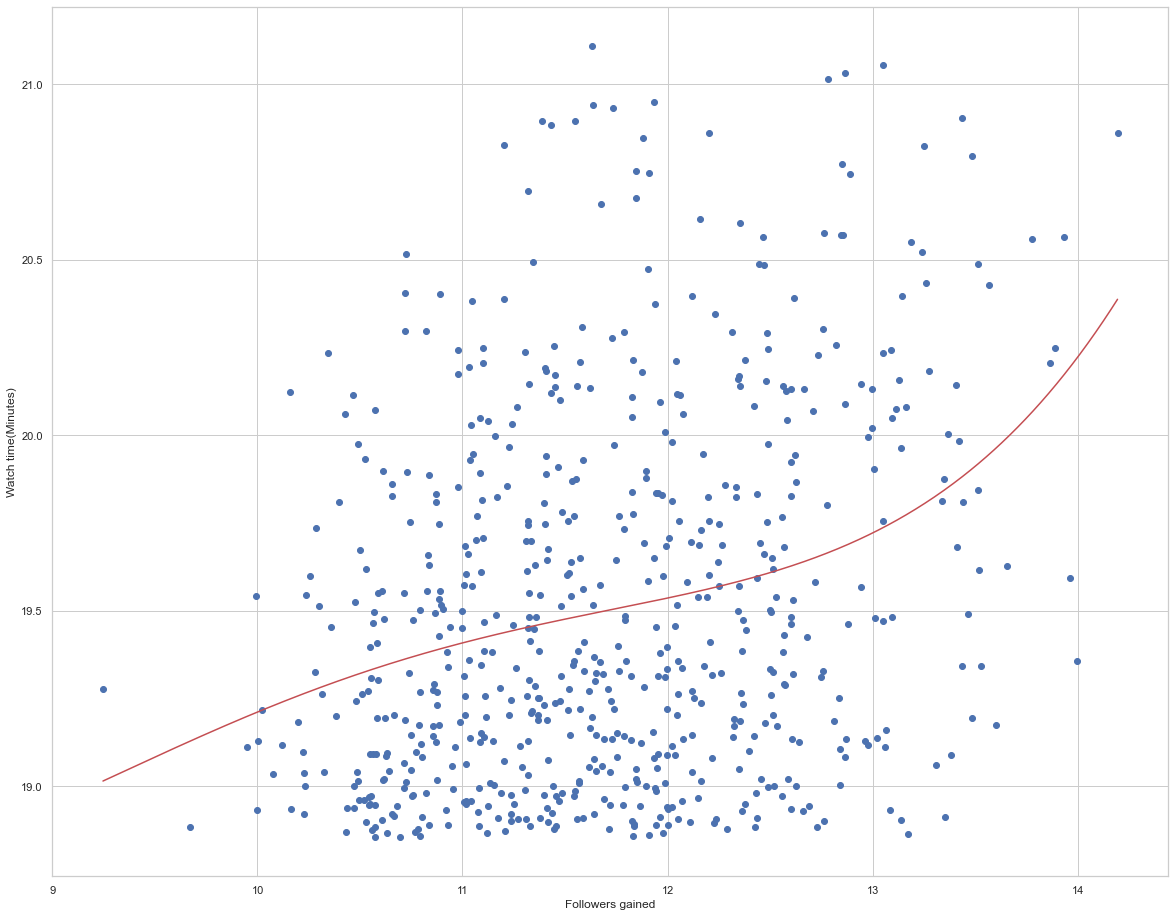

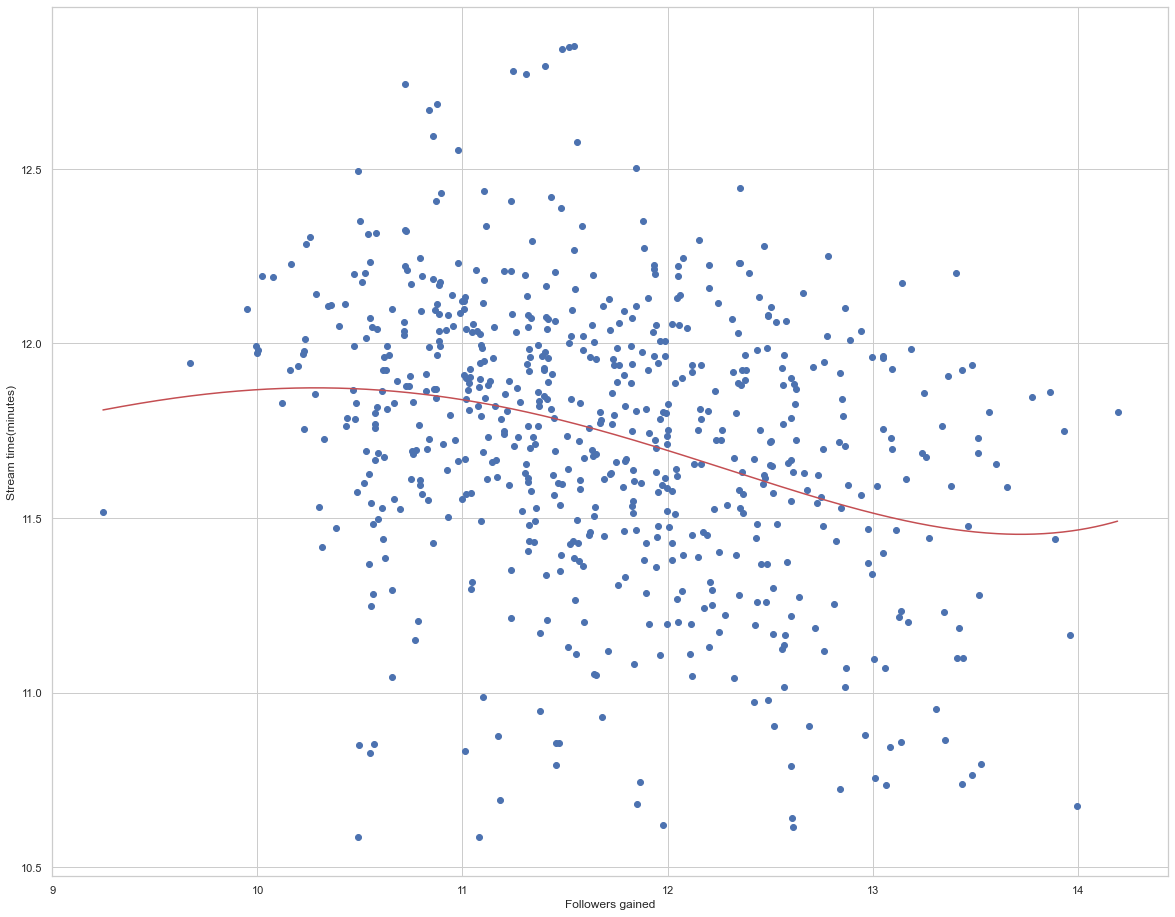

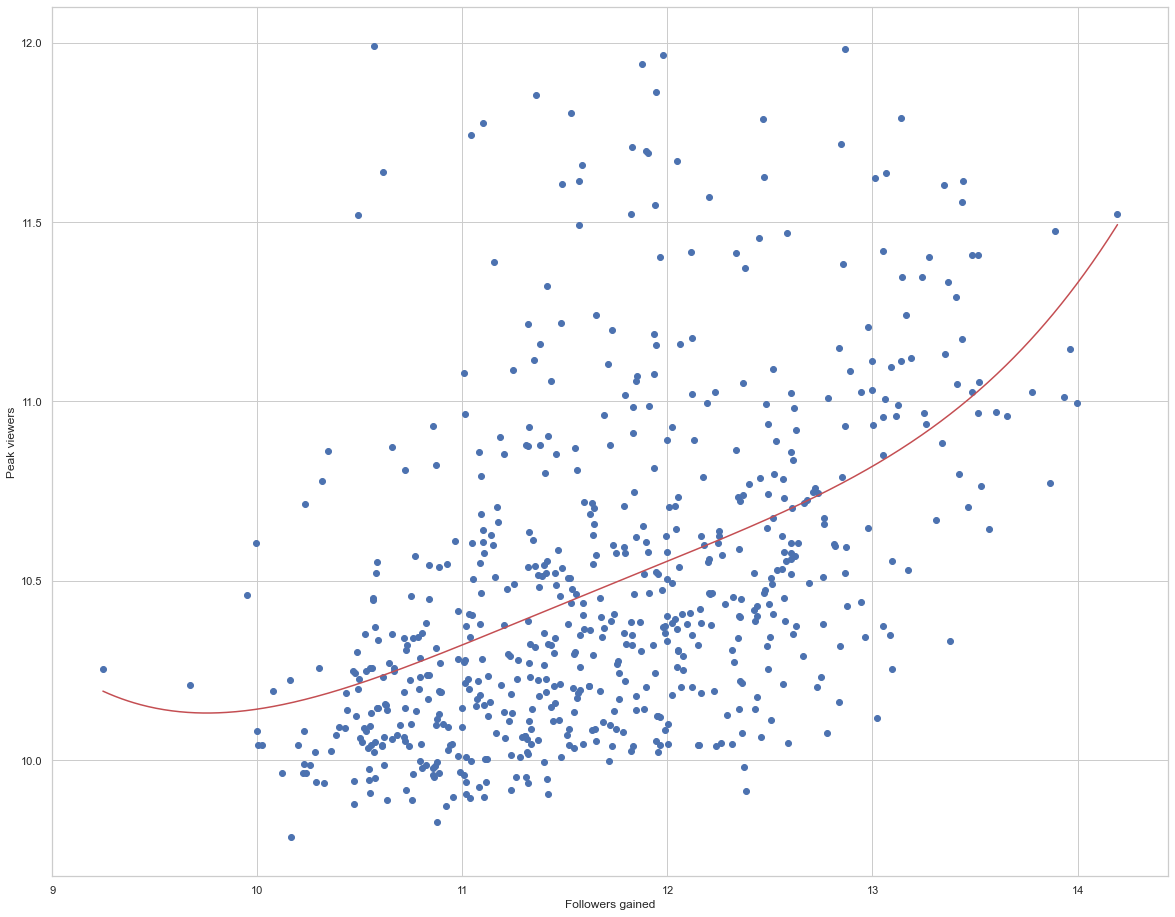

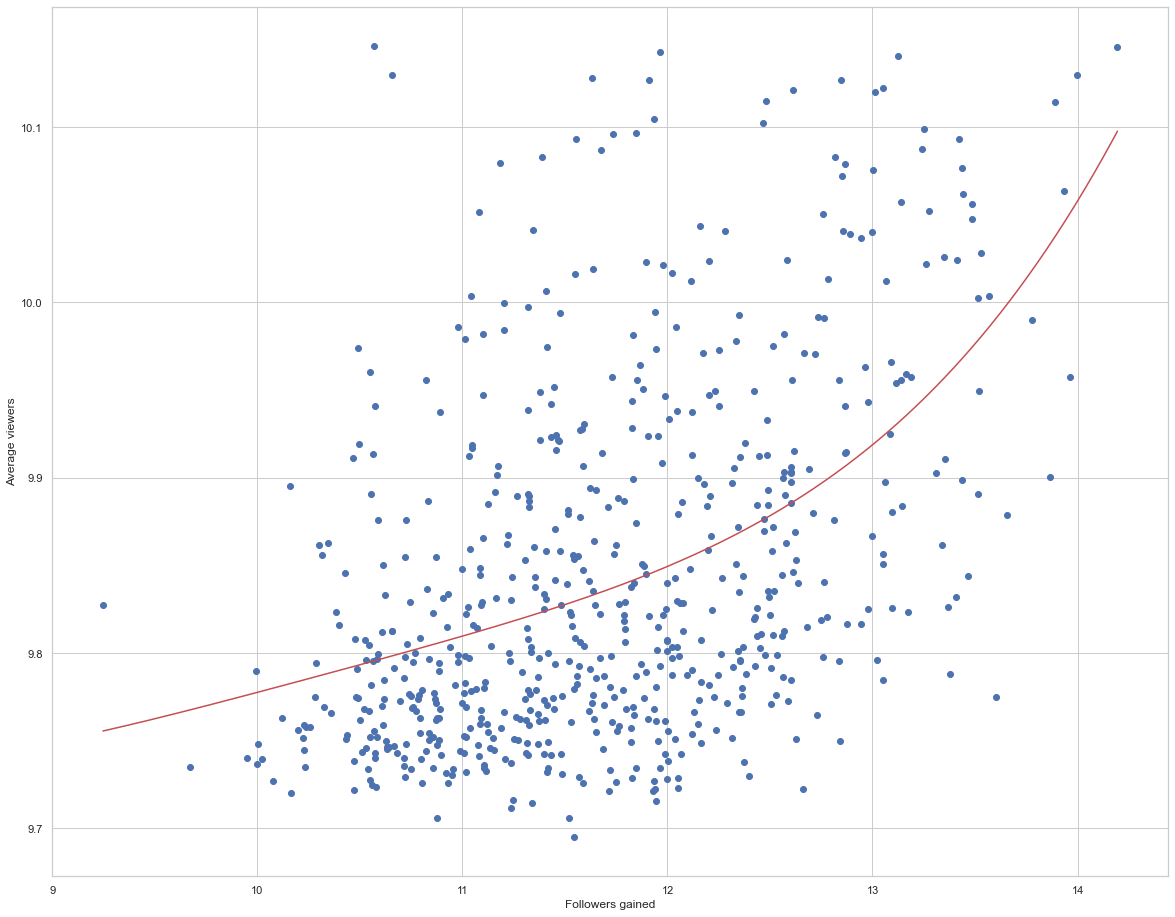

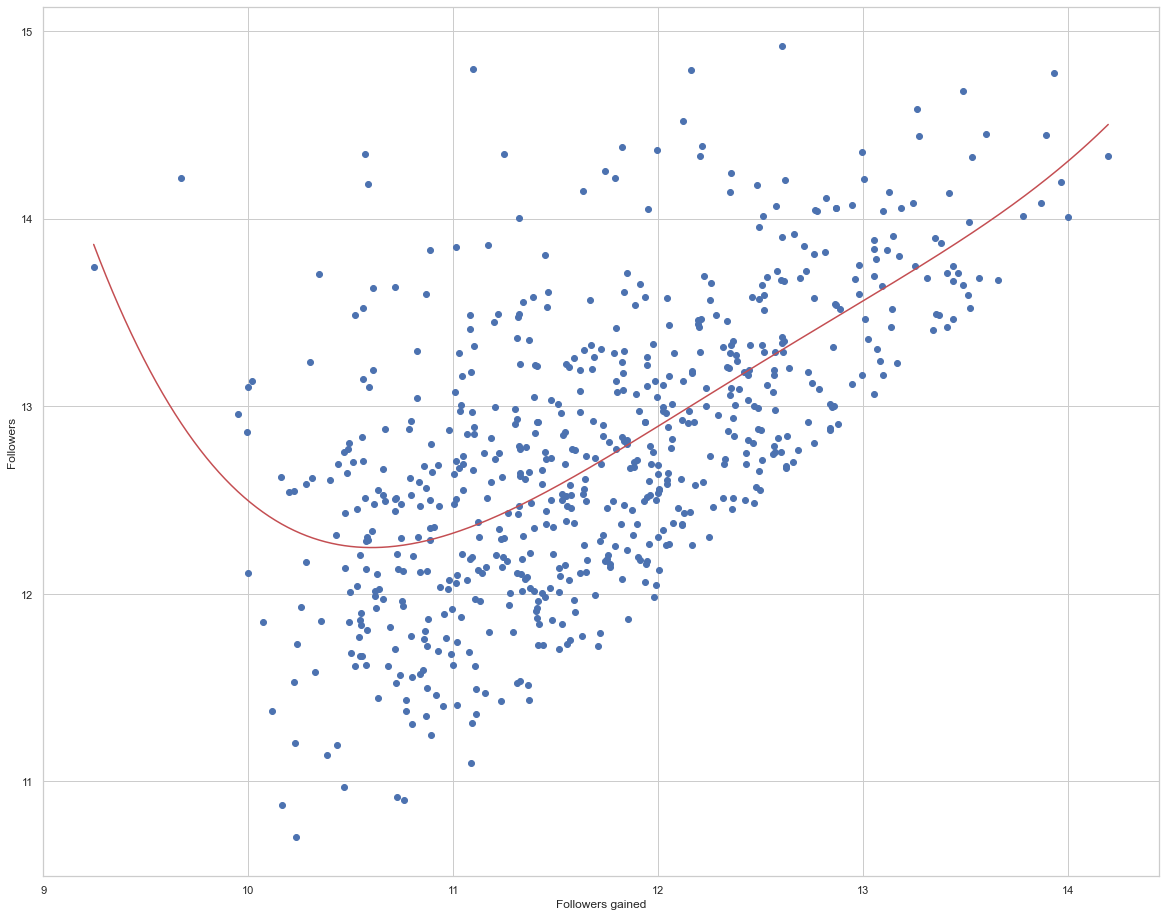

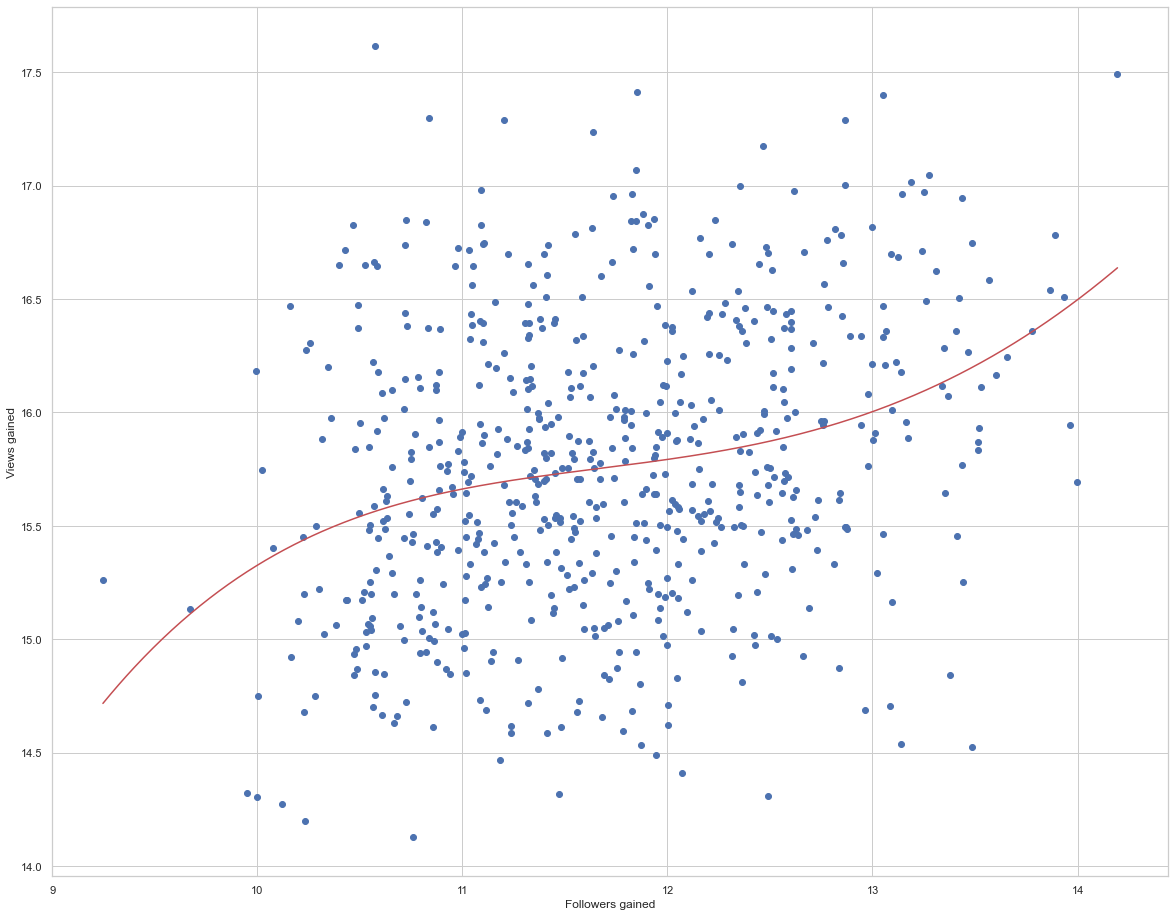

In [17]:
y_columns = numeric.drop('Followers gained', axis=1).columns

for y in y_columns:
    display_reg(fg, y, 4)

In [18]:
equations

{'Watch time(Minutes)': poly1d([ 5.45307018e-03, -2.29703851e-01,  3.58124541e+00, -2.42848707e+01,
         7.91087020e+01]),
 'Stream time(minutes)': poly1d([ 3.43304790e-03, -1.44203147e-01,  2.20468839e+00, -1.45288530e+01,
         4.65599085e+01]),
 'Peak viewers': poly1d([ 9.90810390e-03, -4.59578871e-01,  7.99002842e+00, -6.14744225e+01,
         1.86381103e+02]),
 'Average viewers': poly1d([ 7.56777307e-04, -3.11568810e-02,  4.81841924e-01, -3.28587576e+00,
         1.80411843e+01]),
 'Followers': poly1d([ 2.59598109e-02, -1.30154278e+00,  2.44494327e+01, -2.03279594e+02,
         6.42293769e+02]),
 'Views gained': poly1d([-3.45681196e-03,  2.06627581e-01, -4.40835653e+00,  4.05606763e+01,
        -1.21503641e+02])}

### Artificial Data Generation based on retrieved regression

In [19]:
cols = ['Watch time(Minutes)', 'Stream time(minutes)', 'Peak viewers', 
        'Average viewers', 'Followers', 'Views gained', 'Followers gained']

numeric = numeric.reindex(columns=cols)
numeric.head()

,Watch time(Minutes),Stream time(minutes),Peak viewers,Average viewers,Followers,Views gained,Followers gained
0,21.109149,12.053318,10.716394,10.127790,14.148330,16.813730,11.631295
1,21.055679,11.964370,10.851393,10.122221,13.839044,17.398859,13.051767
2,21.031515,12.100757,11.981922,10.079078,13.544539,17.289888,12.863932
3,21.015458,12.251682,11.009109,10.013059,13.093750,16.466689,12.784322
4,20.948589,11.963415,11.187500,10.104631,12.917794,16.855177,11.936335


In [20]:
fg = numeric['Followers gained']

raf = []
aug_data = pd.DataFrame()

while (len(raf) < 2*(10**3)):
    rand_fg = np.random.randint(fg.min(), fg.max())
    raf.append(rand_fg)
        
for key in equations:
    values = [(equations[key](fg)) for fg in raf]
    aug_data[key] = values

aug_data['Followers gained'] = raf
numeric = numeric.append(aug_data)

numeric.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2649 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Watch time(Minutes)   2649 non-null   float64
 1   Stream time(minutes)  2649 non-null   float64
 2   Peak viewers          2649 non-null   float64
 3   Average viewers       2649 non-null   float64
 4   Followers             2649 non-null   float64
 5   Views gained          2649 non-null   float64
 6   Followers gained      2649 non-null   float64
dtypes: float64(7)
memory usage: 165.6 KB


## Feature Engineering

In [21]:
numeric.head()

,Watch time(Minutes),Stream time(minutes),Peak viewers,Average viewers,Followers,Views gained,Followers gained
0,21.109149,12.053318,10.716394,10.127790,14.148330,16.813730,11.631295
1,21.055679,11.964370,10.851393,10.122221,13.839044,17.398859,13.051767
2,21.031515,12.100757,11.981922,10.079078,13.544539,17.289888,12.863932
3,21.015458,12.251682,11.009109,10.013059,13.093750,16.466689,12.784322
4,20.948589,11.963415,11.187500,10.104631,12.917794,16.855177,11.936335


<AxesSubplot:>

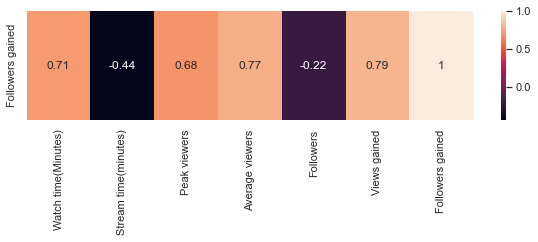

In [22]:
extracted = pd.DataFrame(numeric.corr().loc['Followers gained']).transpose()

figure, ax = plt.subplots(figsize=(10,2))
figure.set_facecolor('white')
sns.heatmap(ax=ax, data=extracted, annot=True)

In [23]:
# How much each viewer spends time in watching the stream?
numeric['Watch time(Minutes)/Average viewers'] = numeric['Watch time(Minutes)'] / numeric['Average viewers']

# If all the followers viewed the stream, how much time would each of them spend?
numeric['Watch time(Minutes)/Followers'] = numeric['Watch time(Minutes)'] / numeric['Followers']

# What proportion of Peak viewers is out of total Followers?
numeric['Peak viewers/Followers'] = numeric['Peak viewers'] / numeric['Followers']

# What proportion of Average viewers is out of total Followers?
numeric['Average viewers/Followers'] = numeric['Average viewers'] / numeric['Followers']

# How much views will be optained from a single minute of streaming?
numeric['Views gained/Stream time(minutes)'] = numeric['Views gained'] / numeric['Stream time(minutes)']

<AxesSubplot:>

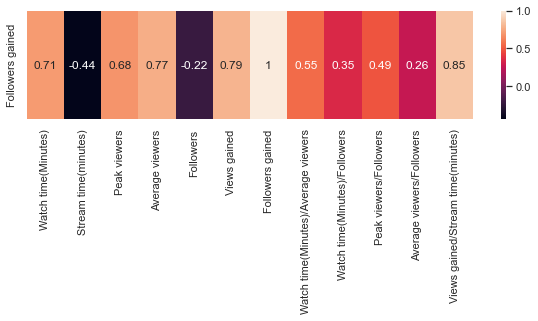

In [24]:
extracted = pd.DataFrame(numeric.corr().loc['Followers gained']).transpose()

figure, ax = plt.subplots(figsize=(10,2))
figure.set_facecolor('white')
sns.heatmap(ax=ax, data=extracted, annot=True)

In [25]:
numeric.head()

,Watch time(Minutes),Stream time(minutes),Peak viewers,Average viewers,Followers,Views gained,Followers gained,Watch time(Minutes)/Average viewers,Watch time(Minutes)/Followers,Peak viewers/Followers,Average viewers/Followers,Views gained/Stream time(minutes)
0,21.109149,12.053318,10.716394,10.127790,14.148330,16.813730,11.631295,2.084280,1.491989,0.757432,0.715829,1.394946
1,21.055679,11.964370,10.851393,10.122221,13.839044,17.398859,13.051767,2.080144,1.521469,0.784114,0.731425,1.454223
2,21.031515,12.100757,11.981922,10.079078,13.544539,17.289888,12.863932,2.086651,1.552767,0.884631,0.744143,1.428827
3,21.015458,12.251682,11.009109,10.013059,13.093750,16.466689,12.784322,2.098805,1.604999,0.840791,0.764721,1.344035
4,20.948589,11.963415,11.187500,10.104631,12.917794,16.855177,11.936335,2.073167,1.621685,0.866053,0.782226,1.408893


In [26]:
numeric.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2649 entries, 0 to 1999
Data columns (total 12 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Watch time(Minutes)                  2649 non-null   float64
 1   Stream time(minutes)                 2649 non-null   float64
 2   Peak viewers                         2649 non-null   float64
 3   Average viewers                      2649 non-null   float64
 4   Followers                            2649 non-null   float64
 5   Views gained                         2649 non-null   float64
 6   Followers gained                     2649 non-null   float64
 7   Watch time(Minutes)/Average viewers  2649 non-null   float64
 8   Watch time(Minutes)/Followers        2649 non-null   float64
 9   Peak viewers/Followers               2649 non-null   float64
 10  Average viewers/Followers            2649 non-null   float64
 11  Views gained/Stream time(minut

## Train, Test, Val Split & Data Scaling

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [28]:
X = numeric.drop('Followers gained', axis=1).values
y = numeric['Followers gained'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.2, random_state=101)

In [29]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
X_val = scaler.fit_transform(X_val)

## Models Generation

In [30]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

### Deep Neural Network

In [31]:
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout
import keras.backend as K
from keras.losses import mean_squared_error as mse

In [32]:
inputs = Input(shape=(11))

x1 = Dense(430, activation='selu', kernel_initializer=keras.initializers.RandomUniform())(inputs)
d1 = Dropout(0.9)(x1)

x2 = Dense(430, activation='selu', kernel_initializer=keras.initializers.RandomUniform())(d1)
d2 = Dropout(0.8)(x2)

x3 = Dense(256, activation='selu', kernel_initializer=keras.initializers.RandomUniform())(d2)
d3 = Dropout(0.7)(x3)

x4 = Dense(256, activation='selu', kernel_initializer=keras.initializers.RandomUniform())(d3)
d4 = Dropout(0.6)(x4)

x5 = Dense(128, activation='selu', kernel_initializer=keras.initializers.RandomUniform())(d4)
d5 = Dropout(0.7)(x5)

x6 = Dense(128, activation='selu', kernel_initializer=keras.initializers.RandomUniform())(d5)
d6 = Dropout(0.9)(x6)

x7 = Dense(32, activation='selu', kernel_initializer=keras.initializers.RandomUniform())(d6)
d7 = Dropout(0.9)(x7)

x8 = Dense(32, activation='selu', kernel_initializer=keras.initializers.RandomUniform())(d7)
d8 = Dropout(0.9)(x8)

outputs = Dense(1)(d8)

model = keras.Model(inputs=inputs, outputs=outputs)

def rmse(y_true, y_pred):
    return K.sqrt(mse(y_true, y_pred))

model.compile(
    loss=rmse, optimizer=keras.optimizers.Adam(learning_rate=0.001)
)

In [33]:
for _ in range(6):
    model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=75)

Epoch 1/75
67/67 [==============================] - 1s 8ms/step - loss: 10.7009 - val_loss: 10.1026
Epoch 2/75
67/67 [==============================] - 0s 6ms/step - loss: 9.1707 - val_loss: 5.2746
Epoch 3/75
67/67 [==============================] - 0s 6ms/step - loss: 7.1444 - val_loss: 1.1845
Epoch 4/75
67/67 [==============================] - 0s 6ms/step - loss: 6.7138 - val_loss: 1.2691
Epoch 5/75
67/67 [==============================] - 0s 6ms/step - loss: 6.1787 - val_loss: 1.1396
Epoch 6/75
67/67 [==============================] - 0s 6ms/step - loss: 6.1462 - val_loss: 1.1661
Epoch 7/75
67/67 [==============================] - 0s 6ms/step - loss: 5.8394 - val_loss: 1.2622
Epoch 8/75
67/67 [==============================] - 0s 6ms/step - loss: 5.7032 - val_loss: 1.2248
Epoch 9/75
67/67 [==============================] - 0s 6ms/step - loss: 5.2859 - val_loss: 1.3586
Epoch 10/75
67/67 [==============================] - 0s 6ms/step - loss: 5.2977 - val_loss: 1.3830
Epoch 11/75
67/67

Epoch 9/75
67/67 [==============================] - 0s 6ms/step - loss: 2.7829 - val_loss: 1.5463
Epoch 10/75
67/67 [==============================] - 0s 6ms/step - loss: 2.7938 - val_loss: 1.4071
Epoch 11/75
67/67 [==============================] - 0s 6ms/step - loss: 2.7756 - val_loss: 1.5240
Epoch 12/75
67/67 [==============================] - 0s 6ms/step - loss: 2.7575 - val_loss: 1.5195
Epoch 13/75
67/67 [==============================] - 0s 6ms/step - loss: 2.7425 - val_loss: 1.4375
Epoch 14/75
67/67 [==============================] - 0s 6ms/step - loss: 2.7577 - val_loss: 1.5830
Epoch 15/75
67/67 [==============================] - 0s 6ms/step - loss: 2.6361 - val_loss: 1.5283
Epoch 16/75
67/67 [==============================] - 0s 6ms/step - loss: 2.6039 - val_loss: 1.4581
Epoch 17/75
67/67 [==============================] - 0s 6ms/step - loss: 2.5882 - val_loss: 1.5185
Epoch 18/75
67/67 [==============================] - 0s 6ms/step - loss: 2.5952 - val_loss: 1.4160
Epoch 19/75

Epoch 17/75
67/67 [==============================] - 0s 6ms/step - loss: 1.3438 - val_loss: 1.1672
Epoch 18/75
67/67 [==============================] - 0s 6ms/step - loss: 1.3786 - val_loss: 1.1452
Epoch 19/75
67/67 [==============================] - 0s 6ms/step - loss: 1.3342 - val_loss: 1.1152
Epoch 20/75
67/67 [==============================] - 0s 6ms/step - loss: 1.3259 - val_loss: 1.1293
Epoch 21/75
67/67 [==============================] - 0s 6ms/step - loss: 1.3546 - val_loss: 1.1380
Epoch 22/75
67/67 [==============================] - 0s 6ms/step - loss: 1.3491 - val_loss: 1.1431
Epoch 23/75
67/67 [==============================] - 0s 6ms/step - loss: 1.3166 - val_loss: 1.1290
Epoch 24/75
67/67 [==============================] - 0s 6ms/step - loss: 1.2997 - val_loss: 1.1194
Epoch 25/75
67/67 [==============================] - 0s 6ms/step - loss: 1.3032 - val_loss: 1.1259
Epoch 26/75
67/67 [==============================] - 0s 6ms/step - loss: 1.2809 - val_loss: 1.1243
Epoch 27/7

Epoch 25/75
67/67 [==============================] - 0s 6ms/step - loss: 0.8990 - val_loss: 0.7081
Epoch 26/75
67/67 [==============================] - 0s 6ms/step - loss: 0.8704 - val_loss: 0.7108
Epoch 27/75
67/67 [==============================] - 0s 6ms/step - loss: 0.8806 - val_loss: 0.7095
Epoch 28/75
67/67 [==============================] - 0s 6ms/step - loss: 0.8697 - val_loss: 0.7017
Epoch 29/75
67/67 [==============================] - 0s 6ms/step - loss: 0.8902 - val_loss: 0.7065
Epoch 30/75
67/67 [==============================] - 0s 6ms/step - loss: 0.8528 - val_loss: 0.7034
Epoch 31/75
67/67 [==============================] - 0s 6ms/step - loss: 0.8507 - val_loss: 0.7054
Epoch 32/75
67/67 [==============================] - 0s 6ms/step - loss: 0.8971 - val_loss: 0.7071
Epoch 33/75
67/67 [==============================] - 0s 6ms/step - loss: 0.8936 - val_loss: 0.7103
Epoch 34/75
67/67 [==============================] - 0s 6ms/step - loss: 0.8772 - val_loss: 0.7087
Epoch 35/7

Epoch 33/75
67/67 [==============================] - 0s 6ms/step - loss: 0.9034 - val_loss: 0.7108
Epoch 34/75
67/67 [==============================] - 0s 6ms/step - loss: 0.8878 - val_loss: 0.7078
Epoch 35/75
67/67 [==============================] - 0s 6ms/step - loss: 0.8746 - val_loss: 0.7087
Epoch 36/75
67/67 [==============================] - 0s 6ms/step - loss: 0.8931 - val_loss: 0.7101
Epoch 37/75
67/67 [==============================] - 0s 6ms/step - loss: 0.8852 - val_loss: 0.7042
Epoch 38/75
67/67 [==============================] - 0s 6ms/step - loss: 0.8861 - val_loss: 0.7109
Epoch 39/75
67/67 [==============================] - 0s 6ms/step - loss: 0.8621 - val_loss: 0.7025
Epoch 40/75
67/67 [==============================] - 0s 6ms/step - loss: 0.9015 - val_loss: 0.7031
Epoch 41/75
67/67 [==============================] - 0s 6ms/step - loss: 0.8693 - val_loss: 0.7032
Epoch 42/75
67/67 [==============================] - 0s 6ms/step - loss: 0.8703 - val_loss: 0.7045
Epoch 43/7

Epoch 41/75
67/67 [==============================] - 0s 6ms/step - loss: 0.8977 - val_loss: 0.7012
Epoch 42/75
67/67 [==============================] - 0s 6ms/step - loss: 0.8563 - val_loss: 0.7038
Epoch 43/75
67/67 [==============================] - 0s 6ms/step - loss: 0.8689 - val_loss: 0.7018
Epoch 44/75
67/67 [==============================] - 0s 6ms/step - loss: 0.8968 - val_loss: 0.7056
Epoch 45/75
67/67 [==============================] - 0s 6ms/step - loss: 0.8819 - val_loss: 0.7089
Epoch 46/75
67/67 [==============================] - 0s 6ms/step - loss: 0.8689 - val_loss: 0.7037
Epoch 47/75
67/67 [==============================] - 0s 6ms/step - loss: 0.8694 - val_loss: 0.7022
Epoch 48/75
67/67 [==============================] - 0s 6ms/step - loss: 0.8631 - val_loss: 0.7060
Epoch 49/75
67/67 [==============================] - 0s 6ms/step - loss: 0.8921 - val_loss: 0.7248
Epoch 50/75
67/67 [==============================] - 0s 6ms/step - loss: 0.8879 - val_loss: 0.7212
Epoch 51/7

### XGBRegressor

In [34]:
from xgboost import XGBRegressor

# Model generation and training
xgb_model = XGBRegressor(objective='reg:linear', 
                         n_estimators=5000, 
                         max_depth=15, 
                         eta=0.001, 
                         subsample=0.8, 
                         colsample_bytree=0.8, 
                         eval_metric='rmse')

xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=0)

# Make predictions
train_pred = xgb_model.predict(X_train)
test_pred = xgb_model.predict(X_test)

# Train set performance
xgb_train_evs = explained_variance_score(y_train, train_pred)
xgb_train_rmse = rmse(y_train, train_pred)

# Test set performance
xgb_test_evs = explained_variance_score(y_test, test_pred)
xgb_test_rmse = rmse(y_test, test_pred)

# Output results
xgb_results = f"""
XGBoost Train EVS: {xgb_train_evs}
XGBoost Train RMSE: {xgb_train_rmse}

XGBoost Test EVS: {xgb_test_evs}
XGBoost Test RMSE: {xgb_test_rmse}
"""

print(xgb_results)

[18:36:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.

XGBoost Train EVS: 0.9967221725930109
XGBoost Train RMSE: 0.11160306632518768

XGBoost Test EVS: 0.8206962522352037
XGBoost Test RMSE: 0.5653136968612671



### LGBMRegressor

In [35]:
from lightgbm import LGBMRegressor as lgb

# Model generation and training
lgb_model = lgb(boosting_type='gbdt', objective='regression',
                num_leaves=150, learning_rate=0.001, n_estimators=10**4)
lgb_model.fit(X_train, y_train)

# Make predictions
train_pred = lgb_model.predict(X_train)
test_pred = lgb_model.predict(X_test)

# Train set performance
lgb_train_evs = explained_variance_score(y_train, train_pred)
lgb_train_rmse = rmse(y_train, train_pred)

# Test set performance
lgb_test_evs = explained_variance_score(y_test, test_pred)
lgb_test_rmse = rmse(y_test, test_pred)

# Output results
lgb_results = f"""
LightGBM Train EVS: {lgb_train_evs}
LightGBM Train RMSE: {lgb_train_rmse}

LightGBM Test EVS: {lgb_test_evs}
LightGBM Test RMSE: {lgb_test_rmse}
"""

print(lgb_results)


LightGBM Train EVS: 0.9909541335491908
LightGBM Train RMSE: 0.12734437360746184

LightGBM Test EVS: 0.7291021113535063
LightGBM Test RMSE: 0.7051050034653298



### Random Forests Regressor

In [36]:
from sklearn.ensemble import RandomForestRegressor

# Model generation and training
forest = RandomForestRegressor(n_estimators=350, verbose=1)
forest.fit(X_train, y_train)

# Make predictions
train_pred = forest.predict(X_train)
test_pred = forest.predict(X_test)

# Train set performance
rf_train_evs = explained_variance_score(y_train, train_pred)
rf_train_rmse = rmse(y_train, train_pred)

# Test set performance
rf_test_evs = explained_variance_score(y_test, test_pred)
rf_test_rmse = rmse(y_test, test_pred)

# Output results
rf_results = f"""
Random Forests Train EVS: {rf_train_evs}
Random Forests Train RMSE: {rf_train_rmse}

Random Forests Test EVS: {rf_test_evs}
Random Forests Test RMSE: {rf_test_rmse}
"""

print(rf_results)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Random Forests Train EVS: 0.9916293434757638
Random Forests Train RMSE: 0.12250121431766495

Random Forests Test EVS: 0.8253945122104884
Random Forests Test RMSE: 0.5759118946412047



[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    0.0s finished


## Stacked Model

In [37]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression

# Models to use
estimators = [
    ('XGBRegressor', xgb_model),
    ('LGBMRegressor', lgb_model),
    ('RFRegressor', forest)
]

# Build Stacked Model
stack_model = StackingRegressor(
    estimators=estimators, final_estimator=LinearRegression()
)

# Train Stacked Model
stack_model.fit(X_train, y_train)

# Make Predictions
sm_train_pred = stack_model.predict(X_train) 
sm_test_pred = stack_model.predict(X_test)

# Train Set Performance
sm_train_evs = explained_variance_score(y_train, sm_train_pred)
sm_train_rmse = rmse(y_train, sm_train_pred)

# Test Set Performance
sm_test_evs = explained_variance_score(y_test, sm_test_pred)
sm_test_rmse = rmse(y_test, sm_test_pred)

# Output results
sm_results = f"""
Stacked Model Train EVS: {sm_train_evs}
Stacked Model Train RMSE: {sm_train_rmse}

Stacked Model Test EVS: {sm_test_evs}
Stacked Model Test RMSE: {sm_test_rmse}
"""

print(sm_results)

[18:36:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    0.9s finished


[18:37:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j


Stacked Model Train EVS: 0.9951542798991415
Stacked Model Train RMSE: 0.09330627216568022

Stacked Model Test EVS: 0.8186408752588219
Stacked Model Test RMSE: 0.571008763622815



## Model Predictions

In [38]:
test = pd.read_csv('Data_Files/test.csv')
test.head()

,Channel,Watch time(Minutes),Stream time(minutes),Peak viewers,Average viewers,Followers,Views gained,Partnered,Mature,Language
0,97R8L3J0,154332060,27105,29983,5864,308815,8255635,0,0,Russian
1,6UV44QFF,154277370,87375,9437,1759,151886,3019137,1,1,French
2,2WKQZUGR,154125945,77475,9460,2106,411346,4832180,1,0,Turkish
3,R4DGVX2D,153988380,83325,11200,1787,272635,4345590,1,0,French
4,P8YSNIOI,153963765,110910,14329,1281,106365,1449834,1,1,English


In [39]:
test.drop(['Channel', 'Partnered', 'Mature', 'Language'], axis=1, inplace=True)
test.head()

,Watch time(Minutes),Stream time(minutes),Peak viewers,Average viewers,Followers,Views gained
0,154332060,27105,29983,5864,308815,8255635
1,154277370,87375,9437,1759,151886,3019137
2,154125945,77475,9460,2106,411346,4832180
3,153988380,83325,11200,1787,272635,4345590
4,153963765,110910,14329,1281,106365,1449834


In [40]:
for col in test.columns:
    print(f"{col}: {test[col].min()}\n")

Watch time(Minutes): 122192850

Stream time(minutes): 3465

Peak viewers: 496

Average viewers: 235

Followers: 7102

Views gained: 956614



In [41]:
test = test.transform(np.log)
test.head()

,Watch time(Minutes),Stream time(minutes),Peak viewers,Average viewers,Followers,Views gained
0,18.854617,10.207473,10.308386,8.676587,12.640498,15.926407
1,18.854263,11.377964,9.152393,7.472501,11.930886,14.920482
2,18.853281,11.257711,9.154828,7.652546,12.927190,15.390808
3,18.852388,11.330504,9.323669,7.488294,12.515889,15.284672
4,18.852228,11.616474,9.570041,7.155396,11.574632,14.186960


In [42]:
test['Watch time(Minutes)/Average viewers'] = test['Watch time(Minutes)'] / test['Average viewers']
test['Watch time(Minutes)/Followers'] = test['Watch time(Minutes)'] / test['Followers']
test['Peak viewers/Followers'] = test['Peak viewers'] / test['Followers']
test['Average viewers/Followers'] = test['Average viewers'] / test['Followers']
test['Views gained/Stream time(minutes)'] = test['Views gained'] / test['Stream time(minutes)']

In [43]:
test.head()

,Watch time(Minutes),Stream time(minutes),Peak viewers,Average viewers,Followers,Views gained,Watch time(Minutes)/Average viewers,Watch time(Minutes)/Followers,Peak viewers/Followers,Average viewers/Followers,Views gained/Stream time(minutes)
0,18.854617,10.207473,10.308386,8.676587,12.640498,15.926407,2.173045,1.491604,0.815505,0.686412,1.560269
1,18.854263,11.377964,9.152393,7.472501,11.930886,14.920482,2.523153,1.580290,0.767118,0.626316,1.311349
2,18.853281,11.257711,9.154828,7.652546,12.927190,15.390808,2.463661,1.458421,0.708184,0.591973,1.367135
3,18.852388,11.330504,9.323669,7.488294,12.515889,15.284672,2.517581,1.506276,0.744947,0.598303,1.348984
4,18.852228,11.616474,9.570041,7.155396,11.574632,14.186960,2.634687,1.628754,0.826812,0.618196,1.221279


In [44]:
test = scaler.fit_transform(test.values)

In [45]:
dnn_pred = model.predict(test)
stack_pred = stack_model.predict(test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    0.0s finished


In [46]:
dnn_pred = dnn_pred.transpose()[0]
predictions = np.divide(np.add(dnn_pred, stack_pred), 2)
predictions = np.exp(predictions).astype(int)

## Export Predictions

In [47]:
channels = pd.read_csv('Data_Files/test.csv')['Channel']
channels = pd.DataFrame(channels)

predictions = pd.DataFrame(predictions)
predictions = predictions.rename(columns={0: 'Followers gained'})

In [48]:
channels.head()

,Channel
0,97R8L3J0
1,6UV44QFF
2,2WKQZUGR
3,R4DGVX2D
4,P8YSNIOI


In [49]:
predictions.head()

,Followers gained
0,183621
1,154873
2,168211
3,149778
4,65074


In [50]:
output = pd.concat([channels, predictions], axis=1)
output.head()

,Channel,Followers gained
0,97R8L3J0,183621
1,6UV44QFF,154873
2,2WKQZUGR,168211
3,R4DGVX2D,149778
4,P8YSNIOI,65074


In [51]:
output.to_csv('Trial_3_Predictions.csv', index=False)